Expand this markdown cell for a surprise!

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$


In [4]:
%load_ext autoreload
%autoreload 2

import banner

topics = ['Linear Model Structure',
          'Fitting Data Samples With A Linear Model',
          'Fitting Data Samples With A Linear Model The Linear Algebra Way',
          'Incremental Way',
          'Example Of SGD In Action',
          'Example of Batch SGD in Action',
          'Example of Batch AdamW in Action',
          'Example of Mini-Batch AdamW in Action',
          'Linear Regression With Fixed Nonlinear Features',
          "Let's Go Sailing!"]

# Fitting Simple Models Using Gradient Descent in the Squared Error

# Linear Model Structure

Given $N$ observations, $\xv_n$, for $n=1,\ldots,N$, and target values,
$t_n$, for $n=1,\ldots,N$, what is the simplest model,
$f(\xv)$, you can think of?

$$
f(\xv) = 0
$$

or maybe

$$
f(\xv) = c
$$

What is next simplest model?

$$
\begin{align*}
   f(\xv;\wv) &= w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D \\
   &= w_0 + \sum_{i=1}^D w_i x_i \\
   & = \sum_{i=0}^D w_i x_i \text{, where } x_0 = 1 \\
   &= \wv^T \xv\\
   &= \xv^T \wv
\end{align*}
$$

  * This is nice because it is linear in the parameters $\wv$; optimizations based on derivatives might be solvable analytically.
  * This is not so nice, because it is also linear in the inputs, $\xv$; greatly limits the complexity of the model.
  *  But, a model linear in the inputs might be the best you can do for many cases, such as a sparsely sampled distribution, process, population, thing...whatever it is you want to model.


# Fitting Data Samples with a Linear Model   

![Springs](http://www.cs.colostate.edu/~anderson/cs545/notebooks/figures/springs.png)

The force exerted by a spring is proportional to its length. The potential
energy stored in the spring is proportional to the square of its length.
Say we want the rod to settle at a position that minimizes the sum of the potential
energies in the springs.

Define the blue dots as the target values, $t_n$ of our data samples.  Each spring is attached to a blue dot at its length of zero.  The predicted value produced by our model $f(x)$ is represented by where the spring attaches to the red bar, vertically above or below the blue dot.
$$
\begin{align*}
\sum_{n=1}^N (t_n - f(\xv_n;\wv))^2
\end{align*}
$$

If $f$ is an affine (linear + constant) function of $x$,
$$
    f(\xv;\wv) = w_0 + w_1 x
$$
with parameters $\wv = (w_0, w_1)$, which parameter values give best fit?
$$
    \wv_{\text{best}} = \argmin{\wv} \sum_{n=1}^N (t_n - f(x_n ; \wv))^2
$$

Set derivative (gradient) with respect to $\wv$ to zero and
solve for $\wv$.  Let's do this with matrices. 

The matrix formulas are a bit simpler if we assume that $w_0$ is multipled by the constant 1, and that $x_{i, 0}$, the first component of sample $i$, is the constant 1.

Collect all targets into matrix $T$ and $x$ samples into matrix
$X$. ($N$=number samples, $D$=sample dimensionality)
$$
  \begin{align*}
    T &= \begin{bmatrix}
      t_1 \\ t_2 \\ \vdots \\ t_N
    \end{bmatrix} \\
    X &= \begin{bmatrix}
      x_{1,0} & x_{1,1} & x_{1,2} & \dotsc & x_{1,D} \\
      x_{2,0} & x_{2,1} & x_{2,2} & \dotsc & x_{2,D} \\
      \vdots \\
      x_{N,0} & x_{N,1} & x_{N,2} & \dotsc & x_{N,D}
    \end{bmatrix}\\
    \wv &= \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_D \end{bmatrix}
  \end{align*}
$$

Collection of all differences is $T - X\wv$, which is an $N \times
1$ matrix.  To form the square of all values and add them up, just
do a dot product $(T-X\wv)^T (T-X\wv)$.  This only works if the value we are predicting is a scalar, which means $T$ is a column matrix.  If we want to predict more than one value for each sample, $T$ will have more than one column.  Let's continue with the derivation assuming $T$ has $K$ columns, meaning we want a linear model with $K$ outputs.

To find the best value for $\wv$, we take the derivative of the sum of squared error objective, set it equal to 0 and solve for $\wv$. Here $\xv_n$ is one sample as a column vector, so it must be transposed to a row vector before being multiplied by the column vector $\wv$.

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (\tv_n - f(\xv_n;\wv))^2}{\partial \wv} &= -2 \sum_{n=1}^N (\tv_n - f(\xv_n;\wv) \frac{\partial f(\xv_n;\wv)}{\partial \wv}\\
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \frac{\partial \xv_n^T \wv}{\partial \wv}\\
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \xv_n^T
\end{align*}
$$

Here's where we get the benefit of expressing the $\xv_n$ and $t_n$ samples as matrices. The sum can be performed with a dot product:

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (\tv_n - f(\xv_n;\wv))^2}{\partial \wv} 
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \xv_n^T\\
&= -2 \Xv^T (\Tv - \Xv \wv)
\end{align*}
$$

Check the sizes and shapes of each matrix in the last equation above.

# Fitting Data Samples with a Linear Model the Linear Algebra Way

Now we can set this equal to zero and solve for $\wv$.

$$
\begin{align*}
-2 \Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T \Tv &= \Xv^T \Xv \wv\\
\wv &= (\Xv^T \Xv)^{-1} \Xv^T \Tv
\end{align*}
$$

And, in python

    w = np.linalg.inv(X.T @ X) @ (X.T @ T)

or, you may use the *solve* function that assumes $\Xv^T \Xv$ is full rank (no linearly dependent columns),

    w = np.linalg.solve(X.T @ X, X.T @ T)

or, better yet, use the *lstsq* function that does not make that assumption. 

    w = np.linalg.lstsq(X.T @ X, X.T @ T)
    
The ```lstsq``` and ```solve``` functions can be written with simpler arguments, like

    w = np.linalg.lstsq(X, T)
    
because they are designed to find the value of $\wv$ that minimized the squared error between $X \wv$ and $T$. 

# Incremental Way

But what if you have thousands or millions of samples?  $X$ and $T$
can be quite large. To avoid dealing with matrix operations on huge
matrices, we can derive a sequential algorithm for finding $\wv$ by
using the fact that a derivative of a sum is the sum of the
derivatives.  We will now express this derivative as a gradient, which is a vector or matrix of derivatives.

$$
\begin{align*}
f(\xv_n, \wv) &= w_0 + w_1 x_{n,1} + w_2 x_{n,2} + \cdots + w_D x_{n,D} = \xv_n^T \wv\\
E(\Xv, \Tv, \wv) &= \sum_{n=1}^N (t_n - f(\xv_n, \wv))^2\\
\nabla_\wv E(\Xv, \Tv, \wv) &= \nabla_\wv \left ( \sum_{n=1}^N (t_n - f(\xv_n, \wv))^2 \right )\\
&= 
\sum_{n=1}^N \nabla_\wv (t_n - f(\xv_n, \wv))^2\\
&= 
\sum_{n=1}^N 2 (t_n - f(\xv_n, \wv)) \nabla_\wv (t_n - f(\xv_n, \wv)) \\
&= 
\sum_{n=1}^N 2 (t_n - f(\xv_n, \wv)) (-1) \nabla_\wv f(\xv_n, \wv) \\
&= 
\sum_{n=1}^N 2 (t_n - f(\xv_n, \wv)) (-1) \nabla_\wv (\xv_n^T \wv) \\
&= 
\sum_{n=1}^N 2 (t_n - f(\xv_n, \wv)) (-1) \xv_n \\
&= 
-2 \sum_{n=1}^N (t_n - f(\xv_n, \wv))  \xv_n \\
\end{align*}
$$

Instead of summing over all $N$ samples, what if we
just update $\wv$ after each sample based on the gradient of $E$ for that sample?  The gradient for a 
sample $n$ can be
considered as a limited, or noisy, sample of the true gradient.
Thus, we can take a small step in the direction of the negative gradient to try
to bring a current guess at the weight vector, $\wv^{(k)}$, on
iteration $k$ to a new value, $\wv^{(k+1)}$, on iteration $k+1$ that is closer to a value that reduces the overall error. This kind of update is called "stochastic approximation".

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \rho (t_n - f(\xv_n, \wv)) \xv_n\\
 &= \wv^{(k)} + \rho (t_n - f(\xv_n, \wv)) \xv_n
\end{align*}
$$

For this sequential algorithm to converge, $\rho$ must decrease with
each iteration, not too fast but not too slow. 

This algorithm is called the least mean squares (LMS) algorithm
developed by Widrow and Hoff.  It is now often referred to as the
**''stochastic gradient descent'' algorithm, or SGD.**

If we have two output variables $t_n$ is no longer a scalar.  How do we deal with that?  Well, to predict two variables, we need two linear models.  We can do this by changing $\wv$ from a single column matrix to a two-column matrix.  The first column could contain the weights used to predict the first target value, and the second column could contain weights to predict the second target value.  Now our linear model is

$$ f(\xv_n, \wv) = \xv_n^T \wv$$

Humm, no change here!  This is the beauty of using matrix math.  The input vector $\xv_n$ is dotted with each of the two columns of $\wv$, resulting in two values, or a two-component resulting vector, giving the predictions for both target values for each sample..

What changes do we need to make to the SGD update formula?  What else must we modify, other than $\wv$?  For each sample, $n$, we must specify two target values, for mpg and horsepower.  So $t_n$ is no longer a scalar, but now has two values in a vector, or $\tv_n$.  To update the weights $\wv$ we must multiply each error by each input component. This does sound like a double loop.  Well, in the last equation above we already used matrix math and ```numpy``` broadcasting once in

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)}  + \rho \; (t_n - f(\xv_n, \wv)) \; \xv_n
\end{align*}
$$

to remove the loop over all of the components in $\wv_n$ and $\xv_n$.  Now we will use broadcasting again to remove a loop over target components, in $\tv_n$.  We must take care to make sure the matrices are of the right shape in the matrix operations, and that the resulting matrix is the correct shape for $\wv$.  Here we follow the convention that vectors are column vectors.

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)}  + \rho \; \xv_n \; (\tv_n^T - f(\xv_n, \wv))) 
\end{align*}
$$

Let's see, $\rho$ is a scalar, $\xv_n$ is $D+1\times 1$, a column vector with $D+1$ components (counting the constant 1), $\tv_n$ is $K\times 1$ if we have $K$ outputs,
so $\tv_n^T$ is $1\times K$  and $f(\xv_n, \wv) = \xv_n^T \wv$ is also $1\times K$.  Stringing these dimensions together in the  calculation gives us $(D+1\times 1) (1\times K)$ which results in $D+1\times K$ exactly the correct shape for our weight matrix $\wv$!

In Python, the update to the weight matrix for the $n^{th}$ sample is just

     w += rho * X1[n:n + 1, :].T * (T[n:n + 1, :] - predicted)

The long, boring, non-matrix way to update each element of `w` would look like

     nOutputs = T.shape[1]
     nInputs = X1.shape[1]
     for k in range(nOutputs):
         for i in range(nInputs):
             w[i,k] += rho * X1[n:n + 1, i] * (T[n:n + 1, k] - predicted[k])

So many lines of code can lead to more bugs!!

`X1[n:n + 1, :]` -> gets the nth row and all columns in that row from X1. Doing this here so that the original dimensions of X1 are kept. If we just did `X1[1, :]` we would get the same row and all its columns, but it would be returned as a 1D array, which we do not want. We want to keep this compatible with `T`.

In [20]:
import numpy as np
X = np.arange(10).reshape(5, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [21]:
X[1, :], X[1, :].shape

(array([2, 3]), (2,))

In [22]:
X[1:2, :], X[1:2, :].shape

(array([[2, 3]]), (1, 2))

In [23]:
X[1:2, :], X[1:2, :].shape

(array([[2, 3]]), (1, 2))

# Example of SGD in Action

In [25]:
# To add interactive controls to plots.  First must [install ipympl](https://matplotlib.org/ipympl/)
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # for the following animation

Let's make some silly data to play with.  Make 100 samples of random $x$ values between 0 and 10, and assign the target for each sample to be $2 - 0.1 X + (X - 6)^2 + \epsilon$, where $\epsilon$ is a bit of noise as a random value from a Normal distribution with mean 0 and standard deviation 0.1.

In [27]:
n_samples = 100
X = np.random.uniform(0, 10, size=(n_samples, 1))
T = 2 - 0.1 * X + 0.05 * (X - 6)**2 + np.random.normal(0, 0.1, (n_samples,1))

(array([  3.,   5.,  14.,  19.,  51.,  70.,  72.,  98., 134., 158., 137.,
        101.,  57.,  45.,  21.,   6.,   6.,   2.,   0.,   1.]),
 array([-0.32436372, -0.28825289, -0.25214206, -0.21603123, -0.1799204 ,
        -0.14380957, -0.10769874, -0.07158791, -0.03547708,  0.00063375,
         0.03674458,  0.07285541,  0.10896625,  0.14507708,  0.18118791,
         0.21729874,  0.25340957,  0.2895204 ,  0.32563123,  0.36174206,
         0.39785289]),
 <BarContainer object of 20 artists>)

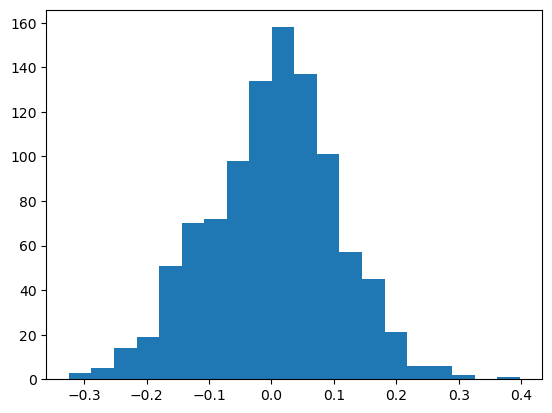

In [28]:
z = np.random.normal(0, 0.1, 1000)
plt.hist(z, 20)

In [29]:
np.random.normal?

Docstring:
normal(loc=0.0, scale=1.0, size=None)

Draw random samples from a normal (Gaussian) distribution.

The probability density function of the normal distribution, first
derived by De Moivre and 200 years later by both Gauss and Laplace
independently [2]_, is often called the bell curve because of
its characteristic shape (see the example below).

The normal distributions occurs often in nature.  For example, it
describes the commonly occurring distribution of samples influenced
by a large number of tiny, random disturbances, each with its own
unique distribution [2]_.

.. note::
    New code should use the `~numpy.random.Generator.normal`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
loc : float or array_like of floats
    Mean ("centre") of the distribution.
scale : float or array_like of floats
    Standard deviation (spread or "width") of the distribution. Must be
    non-negative.
size : int 

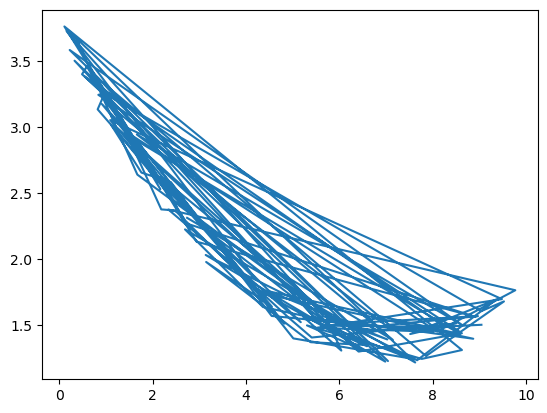

In [30]:
plt.plot(X, T);

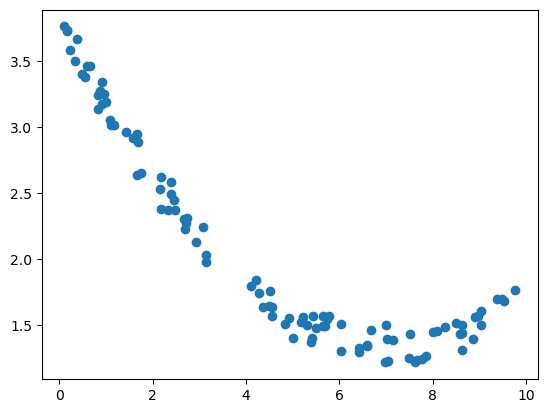

In [31]:
plt.plot(X, T, 'o'); 

Do you think we can fit a linear model to this data?

First, let's modify the $X$ input matrix to include an initial column of constant 1.

In [33]:
X1 = np.insert(X, 0, 1, axis=1)

X1.shape, T.shape

((100, 2), (100, 1))

In [34]:
X1[:5, :]

array([[1.        , 2.73871763],
       [1.        , 7.1421313 ],
       [1.        , 0.99847559],
       [1.        , 5.01229418],
       [1.        , 7.49050695]])

Now we will find good weights by adjusting them to follow the negative gradient of the squared error function using the stochastic gradient descent (SGD) algorithm.

In [36]:
learning_rate = 0.01
n_samples = X1.shape[0]  # number of rows in data equals the number of samples

W = np.zeros((2, 1))                # initialize the weights to zeros
for epoch in range(10):             # train for this many epochs, or passes through the data set
    for n in range(n_samples):
        Y = X1[n:n + 1, :] @ W      # predicted value, y, for sample n
        error = (T[n:n + 1, :] - Y)  # negative gradient of squared error
        
        # update weights by fraction of negative derivative of square error with respect to weights
        W -=  learning_rate * -2 * X1[n:n + 1, :].T * error  
        
print(W)

[[ 3.18604981]
 [-0.13678908]]


Let's instead use the definitions we made in the previous lecture notebook for the gradient of the error with respect to the weights.

In [38]:
def model(X, W):
    return W[0, :] + X @ W[1:, :]

def dYdW(X):
    return np.insert(X, 0, 1, axis=1)

#Gradient of E with respect to Y
def dEdY(Y, T):
    return -2 * (T - Y)
    
# Gradient of E with respect to W.
def dEdW(X, T, Y):
    result = dEdY(Y, T).T @ dYdW(X) / X.shape[0]
    return result.T

In [39]:
learning_rate = 0.01
n_samples = X.shape[0]  # number of rows in data equals the number of samples

W = np.zeros((2, 1))                # initialize the weights to zeros
for epoch in range(10):             # train for this many epochs, or passes through the data set
    for n in range(n_samples):
        # Calculate output of model for sample n
        Y = model(X[n:n + 1, :], W)  
        # update weights by fraction of negative derivative of square error for sample n with respect to weights
        W -=  learning_rate * dEdW(X[n:n + 1, :], T[n:n + 1, :], Y)
        
print(W)

[[ 3.18604981]
 [-0.13678908]]


Let's see how well this linear model (defined by these resulting weights) fits the data.  To do so, we can plot the model's predictions on top of the plot of actual data.

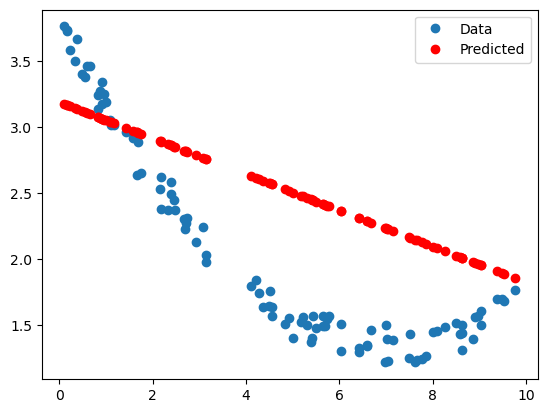

In [61]:
plt.plot(X, T, 'o', label='Data')
plt.plot(X, model(X, W), 'ro', label='Predicted')
plt.legend();

Let's animate each step by drawing the predictions made by the linear model as weights are updated.

In [64]:
def update_plot(fig, X, T, W, ws, sample_indices, n_weight_updates):
    fig.clf()
    
    # Plot the X and T data.
    plt.subplot(2, 1, 1)
    plt.plot(X, T, 'o', alpha=0.6, label='Data')
    plt.plot(X[sample_indices, 0], T[sample_indices], 'ko', ms=10, label='Last Trained Sample')
    
    # Plot the output of our linear model for a range of x values
    xs = np.linspace(0, 10, 100).reshape((-1, 1))
    plt.plot(xs, model(xs, W), 'r-', linewidth=5, label='Model')
    plt.xlabel('$x$')
    plt.legend(loc='upper right')
    plt.xlim(0, 10)
    plt.ylim(0, 5)
    
    # In second panel plot the weights versus the epoch number
    plt.subplot(2, 1, 2)
    plt.plot(np.array(ws)[:, :, 0])
    plt.xlabel('Updates')
    plt.xlim(0, n_weight_updates)
    plt.ylim(-1, 3.3)
    plt.legend(('$w_0$', '$w_1$'))
    
    clear_output(wait=True)
    display(fig)

    
def run(learning_rate, n_epochs, stepsPerFrame=10):

    # Initialize weights to all zeros
    # For this demonstration, we will have one variable input. With the constant 1 input, we have 2 weights.
    W = np.zeros((2,1))

    # Collect the weights after each update in a list for later plotting. 
    # This is not part of the training algorithm
    ws = [W.copy()]

    fig = plt.figure(figsize=(8, 8))

    # For each pass (one epoch) through all samples ...
    for iter in range(n_epochs):
        # For each sample ...
        for n in range(n_samples):
        
            # Calculate output of model for sample n
            Y = model(X[n:n + 1, :], W)  
            # update weights by fraction of negative derivative of square error for sample n with respect to weights
            W -= learning_rate * dEdW(X[n:n + 1, :], T[n:n + 1, :], Y)

            # Add new w to our list of past w values for plotting
            ws.append(W.copy())
        
            if n % stepsPerFrame == 0:
                sample_indices = n
                update_plot(fig, X, T, W, ws, sample_indices, n_epochs * n_samples)
    
    clear_output(wait=True)
    
    return W

array([[1.40221207],
       [0.0113777 ]])

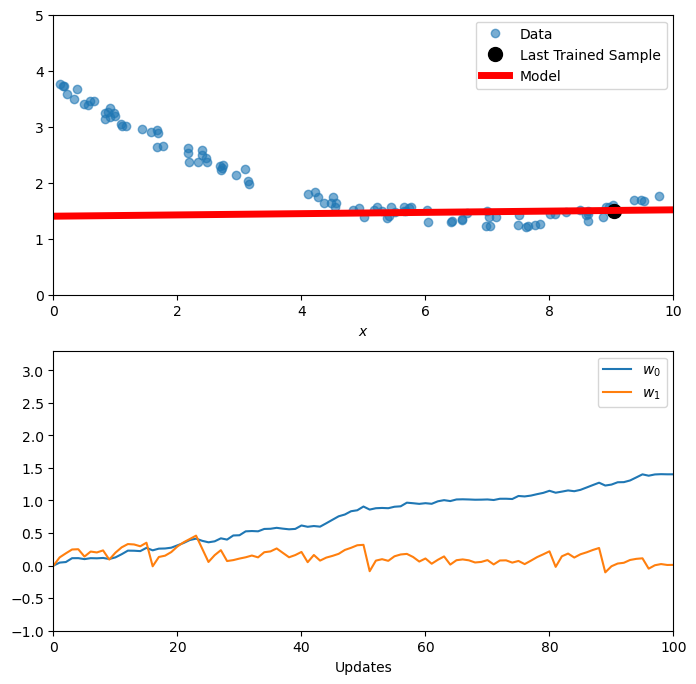

In [66]:
run(0.01, n_epochs=1, stepsPerFrame=1)

array([[ 3.19658188],
       [-0.13766388]])

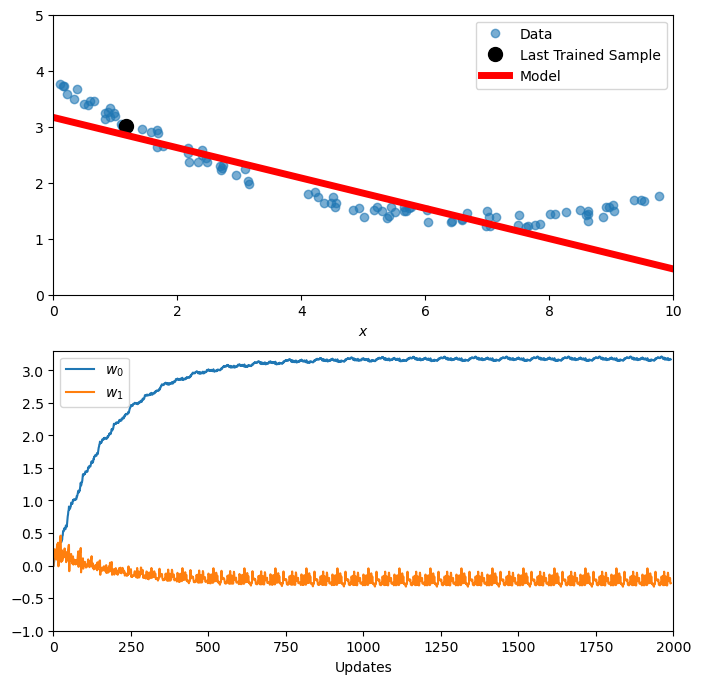

In [68]:
run(0.01, n_epochs=20, stepsPerFrame=10)

# Example of Batch SGD in Action

Recall that our inner most for loop is updating the weights once for each sample.  Instead, we can accumulate the gradient calculations for all samples and update the weights once at the end of one pass, or epoch, through the samples.  This is refereed to as *batch* training.

Where is the accumlation happening in the following code???

In [74]:
def run_batch(learning_rate, n_epochs, stepsPerFrame=10):

    # Initialize weights to all zeros
    # For this demonstration, we will have one variable input. With the constant 1 input, we have 2 weights.
    W = np.zeros((2,1))

    # Collect the weights after each update in a list for later plotting. 
    # This is not part of the training algorithm
    ws = [W.copy()]

    fig = plt.figure(figsize=(8, 8))

    # For each pass (one epoch) through all samples ...
    for epoch in range(n_epochs):
    
        Y = model(X, W)  # not using the n:n+1 to select just one sample. Using them all.
        W -= learning_rate * dEdW(X, T, Y)

        # Add new w to our list of past w values for plotting
        ws.append(W.copy())
    
        if epoch % stepsPerFrame == 0:
            sample_indices = range(X.shape[0])
            update_plot(fig, X, T, W, ws, sample_indices, n_epochs)
    
    clear_output(wait=True)
    
    return W

array([[ 2.15984964],
       [-0.08040273]])

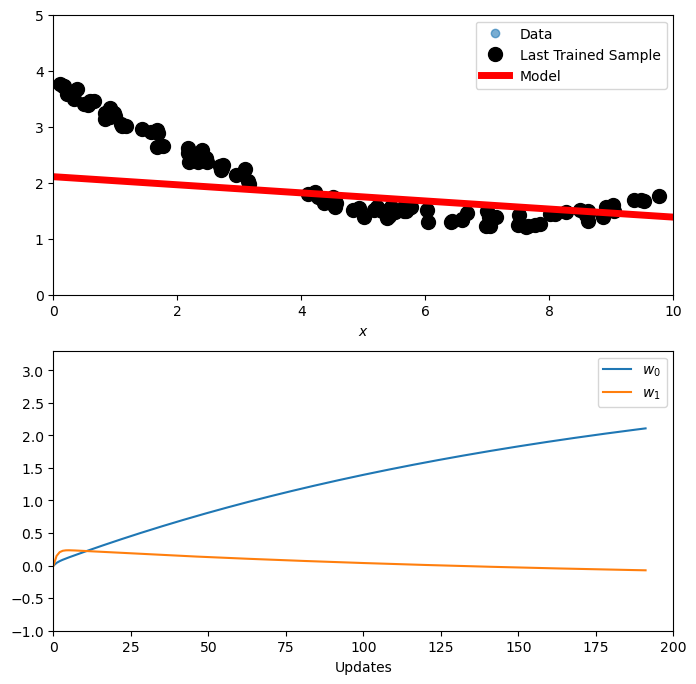

In [76]:
run_batch(0.01, n_epochs=200, stepsPerFrame=10)

array([[ 2.83887812],
       [-0.18677134]])

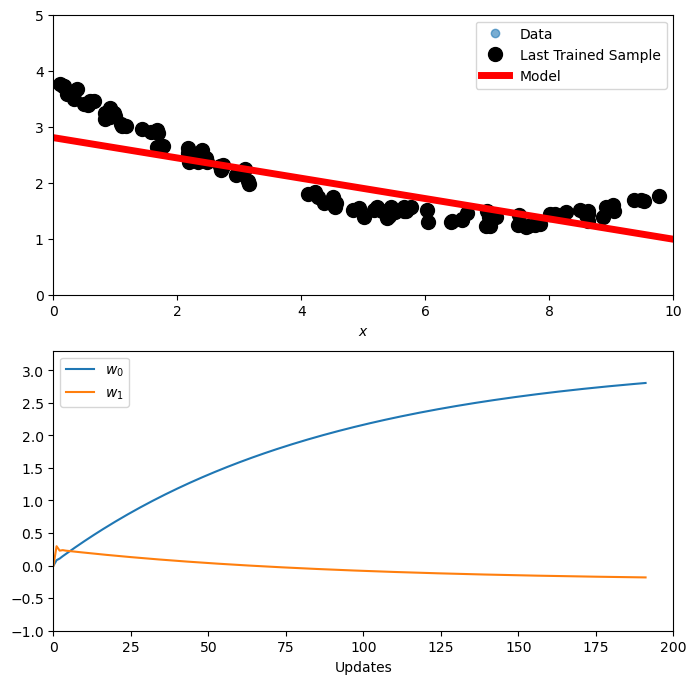

In [78]:
run_batch(0.02, n_epochs=200, stepsPerFrame=10)

array([[ 3.0549066 ],
       [-0.22061182]])

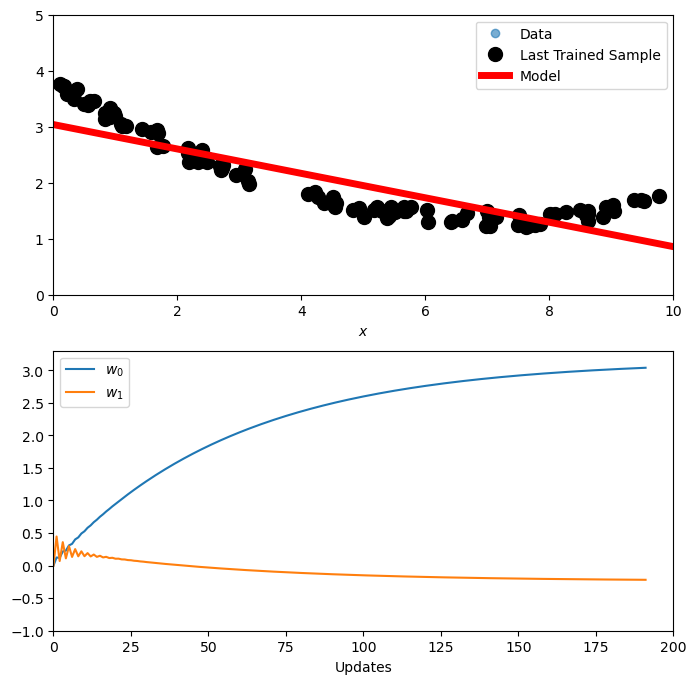

In [80]:
run_batch(0.03, n_epochs=200, stepsPerFrame=10)

# Example of Batch AdamW in Action

Now, do it again with our alternative gradient descent algorithm, AdamW.

In [82]:
def run_batch_adamw(learning_rate, n_epochs, stepsPerFrame=10):

    # Initialize weights to all zeros
    # For this demonstration, we will have one variable input. With the constant 1 input, we have 2 weights.
    W = np.zeros((2,1))

    # Collect the weights after each update in a list for later plotting. 
    # This is not part of the training algorithm
    ws = [W.copy()]

    # Initialize adamw parameters
    beta1 = 0.9
    beta2 = 0.99
    epsilon = 1e-8
    W_decay_rate = 0.1
    m = 0
    v = 0

    # Create a bunch of x values for plotting
    xs = np.linspace(0, 10, 100).reshape((-1, 1))

    fig = plt.figure(figsize=(8, 8))

    # For each pass (one epoch) through all samples ...
    for epoch in range(n_epochs):
    
        Y = model(X, W)  # not using the n:n+1 to select just one sample. Using them all.        
        gradient = dEdW(X, T, Y)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * gradient * gradient
        mhat = m / (1 - beta1 ** (epoch + 1))
        vhat = v / (1 - beta2 ** (epoch + 1))
        W -= learning_rate * mhat / (np.sqrt(vhat) + epsilon) + W_decay_rate * W

        # Add new w to our list of past w values for plotting
        ws.append(W.copy())
    
        if epoch % stepsPerFrame == 0:
            sample_indices = range(X.shape[0])
            update_plot(fig, X, T, W, ws, sample_indices, n_epochs)
    
    clear_output(wait=True)

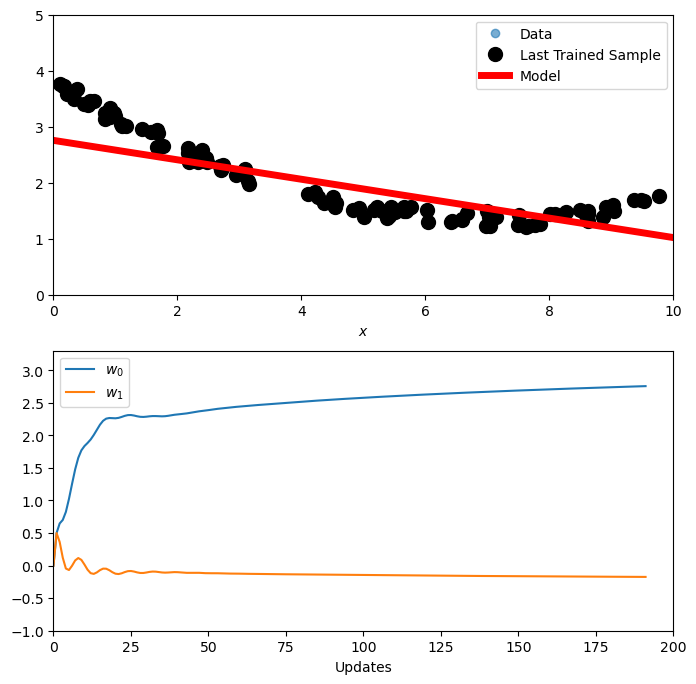

In [84]:
run_batch_adamw(0.5, n_epochs=200, stepsPerFrame=10)

# Example of Minibatch AdamW in Action

Seems like a compromise might result in faster training.  Perhaps training on "mini-batches" would go faster.  We will have more weight updates per epoch, and mini-batches will are likely to include samples whose gradients are less noisy.

Let's add an argument that is the mini-batch size.  We can then iterate over the mini-batches in each epoch.  At the start of each epoch first randomly rearrange the data samples so mini-batches will be different each epoch.

Oooo, oooo!   Sounds like a great place for a python generator!

In [98]:
def f(n):
    for i in range(n):
        yield [i, i*i]

for result in f(10):
    print(result)

[0, 0]
[1, 1]
[2, 4]
[3, 9]
[4, 16]
[5, 25]
[6, 36]
[7, 49]
[8, 64]
[9, 81]


In [100]:
f(5)

<generator object f at 0x3205c9080>

In [126]:
def next_minibatch(X, T, batch_size):
    # rows is range of ints from 0 - X.shape[0] size
    rows = np.arange(X.shape[0])
    # shuffles these ints in random order
    np.random.shuffle(rows)
    n_samples = X.shape[0]
    # rearranges rows of X and T to match new random order of rows
    X = X[rows, :]
    T = T[rows, :]
    for first in range(0, n_samples, batch_size):
        last = first + batch_size
        if last > n_samples:
            break
        yield X[first:last, :], T[first:last, :], rows[first:last]

A = np.arange(2 * 10).reshape(-1, 2)
B = -np.arange(2 * 10).reshape(-1, 2)

A, B
    
    

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19]]),
 array([[  0,  -1],
        [ -2,  -3],
        [ -4,  -5],
        [ -6,  -7],
        [ -8,  -9],
        [-10, -11],
        [-12, -13],
        [-14, -15],
        [-16, -17],
        [-18, -19]]))

In [124]:
for a, b, rows in next_minibatch(A, B, 4):
    print(a, b, rows)

[[ 2  3]
 [ 0  1]
 [ 8  9]
 [12 13]] [[ -2  -3]
 [  0  -1]
 [ -8  -9]
 [-12 -13]] [1 0 4 6]
[[10 11]
 [16 17]
 [ 4  5]
 [14 15]] [[-10 -11]
 [-16 -17]
 [ -4  -5]
 [-14 -15]] [5 8 2 7]


In [128]:
def run_minibatch_adamw(learning_rate, n_epochs, batch_size, stepsPerFrame=10):

    # Initialize weights to all zeros
    # For this demonstration, we will have one variable input. With the constant 1 input, we have 2 weights.
    W = np.zeros((2,1))

    # Collect the weights after each update in a list for later plotting. 
    # This is not part of the training algorithm
    ws = [W.copy()]

    # Initialize adamw parameters
    beta1 = 0.9
    beta2 = 0.99
    epsilon = 1e-8
    W_decay_rate = 0.1
    m = 0
    v = 0

    # Create a bunch of x values for plotting
    xs = np.linspace(0, 10, 100).reshape((-1, 1))

    fig = plt.figure(figsize=(8, 8))

    # For each pass (one epoch) through all samples ...
    iter = 0
    for epoch in range(n_epochs):
        for Xbatch, Tbatch, sample_indices in next_minibatch(X, T, batch_size):
    
            Ybatch = model(Xbatch, W)  # not using the n:n+1 to select just one sample. Using them all.        
            gradient = dEdW(Xbatch, Tbatch, Ybatch)
        
            m = beta1 * m + (1 - beta1) * gradient
            v = beta2 * v + (1 - beta2) * gradient * gradient
            mhat = m / (1 - beta1 ** (epoch + 1))
            vhat = v / (1 - beta2 ** (epoch + 1))
            W -= learning_rate * mhat / (np.sqrt(vhat) + epsilon) + W_decay_rate * W

            # Add new w to our list of past w values for plotting
            ws.append(W.copy())
    
            iter += 1
            if iter % stepsPerFrame == 0:
                update_plot(fig, X, T, W, ws, sample_indices, n_epochs * X.shape[0] / batch_size)
            
    clear_output(wait=True)

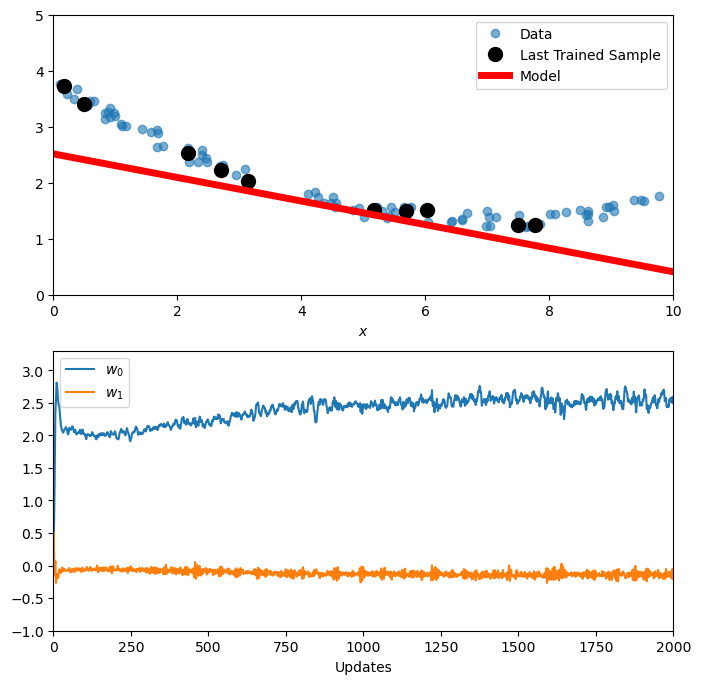

In [130]:
run_minibatch_adamw(0.5, n_epochs=200, batch_size=10, stepsPerFrame=10)

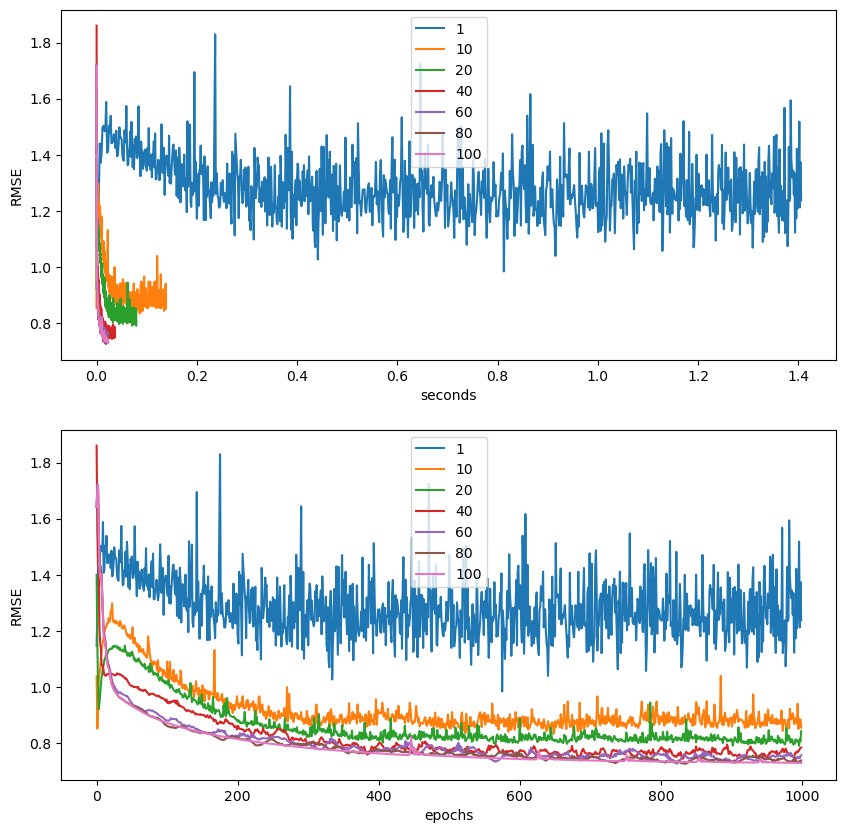

In [132]:
import time

def rmse(Y, T):
    return np.sqrt(np.mean((Y - T) ** 2))
    
def run_minibatch_adamw_no_graphics(learning_rate, n_epochs, batch_size):

    W = np.zeros((2,1))
    ws = [W.copy()]

    # Initialize adamw parameters
    beta1 = 0.9
    beta2 = 0.99
    epsilon = 1e-8
    W_decay_rate = 0.1
    m = 0
    v = 0

    start_time = time.time()
    time_epoch_error = []
    # For each pass (one epoch) through all samples ...
    for epoch in range(n_epochs):
        for Xbatch, Tbatch, sample_indices in next_minibatch(X, T, batch_size):
    
            Ybatch = model(Xbatch, W)  # not using the n:n+1 to select just one sample. Using them all.        
            gradient = dEdW(Xbatch, Tbatch, Ybatch)
        
            m = beta1 * m + (1 - beta1) * gradient
            v = beta2 * v + (1 - beta2) * gradient * gradient
            mhat = m / (1 - beta1 ** (epoch + 1))
            vhat = v / (1 - beta2 ** (epoch + 1))
            W -= learning_rate * mhat / (np.sqrt(vhat) + epsilon) + W_decay_rate * W

        time_epoch_error.append([time.time() - start_time, epoch, rmse(model(X, W), T)])
    return np.array(time_epoch_error)

n_epochs = 1000
learning_rate = 0.2
batch_sizes = [1, 10, 20, 40, 60, 80, 100]
results = []
for batch_size in batch_sizes:
    results.append(run_minibatch_adamw_no_graphics(learning_rate, n_epochs, batch_size))

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
for result, batch_size in zip(results, batch_sizes):
    plt.plot(result[:,0], result[:, 2], label=batch_size)
plt.xlabel('seconds')
plt.ylabel('RMSE')
# plt.xlim(0, 0.2)
plt.legend();

plt.subplot(2, 1, 2)
for result, batch_size in zip(results, batch_sizes):
    plt.plot(result[:,1], result[:, 2], label=batch_size)
plt.xlabel('epochs')
plt.ylabel('RMSE')

plt.legend();

# Linear Regression with Fixed Nonlinear Features

The models we have been buildling are linear in the parameters $\wv$
and linear in the attributes (features) of the samples.  We can make
models that are nonlinear in the attributes by adding nonlinear
functions of the original features.  

Say we have a single feature for each sample.  Our data matrix is
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0\\
       x_1\\
       \vdots \\
       x_N
       \end{bmatrix}
\end{alignat*}
$$
We can add other powers of each $x$ value, say up to the fourth power.
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0 & x_0^2 & x_0^3 & x_0^4\\
       x_1 & x_1^2 & x_1^3 & x_1^4\\
       \vdots \\
       x_N & x_N^2 & x_N^3 & x_N^4\\
       \end{bmatrix}
\end{alignat*}
$$

This is simple to do in python.

In [134]:
X = np.array([1.1, 2.3, 6.2, 4.2]).reshape(-1, 1)
X

array([[1.1],
       [2.3],
       [6.2],
       [4.2]])

In [136]:
X ** 2

array([[ 1.21],
       [ 5.29],
       [38.44],
       [17.64]])

In [138]:
X ** [1, 2, 3]

array([[  1.1  ,   1.21 ,   1.331],
       [  2.3  ,   5.29 ,  12.167],
       [  6.2  ,  38.44 , 238.328],
       [  4.2  ,  17.64 ,  74.088]])

In [140]:
X ** range(1, 4)

array([[  1.1  ,   1.21 ,   1.331],
       [  2.3  ,   5.29 ,  12.167],
       [  6.2  ,  38.44 , 238.328],
       [  4.2  ,  17.64 ,  74.088]])

Hey, we can raise X to an exponent of 0 to include the initial column of constant 1 values!

In [143]:
X ** range(0, 4)

array([[  1.   ,   1.1  ,   1.21 ,   1.331],
       [  1.   ,   2.3  ,   5.29 ,  12.167],
       [  1.   ,   6.2  ,  38.44 , 238.328],
       [  1.   ,   4.2  ,  17.64 ,  74.088]])

But, what if we have more than 1 input feature in X?

In [146]:
X = np.arange(10).reshape(5, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [148]:
X ** 2

array([[ 0,  1],
       [ 4,  9],
       [16, 25],
       [36, 49],
       [64, 81]])

In [150]:
X ** [2, 3, 4]

ValueError: operands could not be broadcast together with shapes (5,2) (3,) 

In [ ]:
X ** np.array([2, 3, 4])

Rats!   Not working. We must assemble our powers of X one at a time.

In [152]:
[X ** p for p in [1, 2, 3]]

[array([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]]),
 array([[ 0,  1],
        [ 4,  9],
        [16, 25],
        [36, 49],
        [64, 81]]),
 array([[  0,   1],
        [  8,  27],
        [ 64, 125],
        [216, 343],
        [512, 729]])]

In [154]:
np.hstack([X ** p for p in [1, 2, 3]])

array([[  0,   1,   0,   1,   0,   1],
       [  2,   3,   4,   9,   8,  27],
       [  4,   5,  16,  25,  64, 125],
       [  6,   7,  36,  49, 216, 343],
       [  8,   9,  64,  81, 512, 729]])

In [156]:
def make_powers(X, max_power):
    return np.hstack([X ** p for p in range(1, max_power + 1)])

Which of these powers of $x$ are useful?  Looking at the magnitudes of
the weights is helpful, as long as the input features have similar ranges.  A typical way to force this is to *standardize* the inputs.  This usually means the we subtract the mean of each feature from the values of that feature, then divide by its standard deviation.  So we must first calculate the column means and column standard deviations of $X$.  No worries, `numpy` can do that!

        Xst = (X - np.mean(X, axis=0)) / np.std(X, axis=0)      
We will be standardizing inputs like this throughout the semester.

In [159]:
def train(X, T, n_epochs, learning_rate):
    
    means = X.mean(0)
    stds = X.std(0)
    # Replace stds of 0 with 1 to avoid dividing by 0.
    stds[stds == 0] = 1
    Xst = (X - means) / stds
    
    # Xst = np.insert(Xst, 0, 1, axis=1)  # Insert column of 1's as first column in Xst
    
    # n_samples, n_inputs = Xst.shape[0]
    n_samples, n_inputs = Xst.shape
    
    # Initialize weights to all zeros
    W = np.zeros((n_inputs + 1, 1))  # matrix of one column
    
    # Repeat updates for all samples for multiple passes, or epochs,
    for epoch in range(n_epochs):
        Y = model(Xst, W)
        W -= learning_rate * dEdW(Xst, T, Y)
                
    # Return a dictionary containing the weight matrix and standardization parameters.
    return {'W': W, 'means' : means, 'stds' :stds, 'max_power': max_power}

def use(model, model_parms, X):
    Xst = (X - model_parms['means']) / model_parms['stds']
    Y = model(Xst, model_parms['W'])
    return Y

def rmse(A, B):
    return np.sqrt(np.mean( (A - B)**2 ))

Now, let's go back to the one-dimensional samples we had above.

In [162]:
n_samples = 100
X = np.random.uniform(0, 10, (n_samples, 1))
T = 2 - 0.1 * X + 0.05 * (X - 6)**2 + np.random.normal(0, 0.1, (n_samples,1))

In [164]:
max_power = 5
X_powers = make_powers(X, max_power)

n_epochs = 2000
learning_rate = 0.02

model_parms = train(X_powers, T, n_epochs, learning_rate)


In [166]:
Y = use(model, model_parms, X_powers)

In [168]:
X.shape

(100, 1)

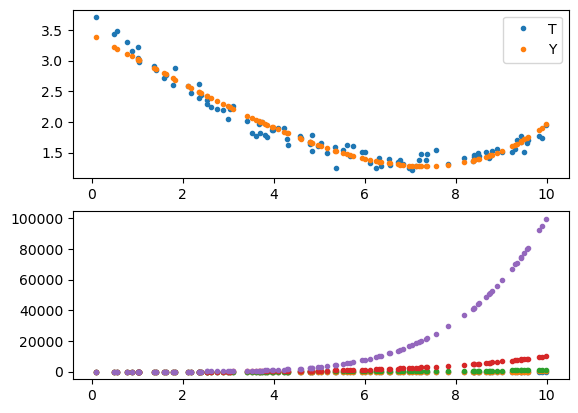

In [170]:
plt.subplot(2, 1, 1)
plt.plot(X, T, '.', label='T')
plt.plot(X, Y, '.', label='Y')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X, X_powers, '.');

In [172]:
model_parms.keys()

dict_keys(['W', 'means', 'stds', 'max_power'])

In [174]:
model_parms['W']

array([[ 1.89808921],
       [-1.12660342],
       [ 0.00325989],
       [ 0.30590131],
       [ 0.28168992],
       [ 0.14151235]])

In [176]:
W = model_parms['W']
for i in range(W.shape[0]):
    if i == 0:
        print(f'Bias weight: W is {W[i, 0]:5.2f}')
    else:
        print(f'Power {i}: W is {W[i, 0]:5.2f}')

Bias weight: W is  1.90
Power 1: W is -1.13
Power 2: W is  0.00
Power 3: W is  0.31
Power 4: W is  0.28
Power 5: W is  0.14


Now let's try some other data.  Here is some data related to the design of hulls on yachts.

# Let's Go Sailing!

In [178]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
!head yacht_hydrodynamics.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11487    0 11487    0     0  16870      0 --:--:-- --:--:-- --:--:-- 16892
-2.3 0.568 4.78 3.99 3.17 0.125 0.11
-2.3 0.568 4.78 3.99 3.17 0.150 0.27
-2.3 0.568 4.78 3.99 3.17 0.175 0.47
-2.3 0.568 4.78 3.99 3.17 0.200 0.78
-2.3 0.568 4.78 3.99 3.17 0.225 1.18
-2.3 0.568 4.78 3.99 3.17 0.250 1.82
-2.3 0.568 4.78 3.99 3.17 0.275 2.61
-2.3 0.568 4.78 3.99 3.17 0.300 3.76
-2.3 0.568 4.78 3.99 3.17 0.325 4.99
-2.3 0.568 4.78 3.99 3.17 0.350 7.16


In [180]:
data = np.loadtxt('yacht_hydrodynamics.data')

T = data[:, -1:]
X = data[:, :-1]
Xnames = ['Center of Buoyancy', 'Prismatic coefficient', 'Length-displacement ratio', 'Beam-draught ratio',
          'Length-beam ratio', 'Froude number']
Tname = 'Resistance'
X.shape, T.shape, Xnames, Tname

((308, 6),
 (308, 1),
 ['Center of Buoyancy',
  'Prismatic coefficient',
  'Length-displacement ratio',
  'Beam-draught ratio',
  'Length-beam ratio',
  'Froude number'],
 'Resistance')

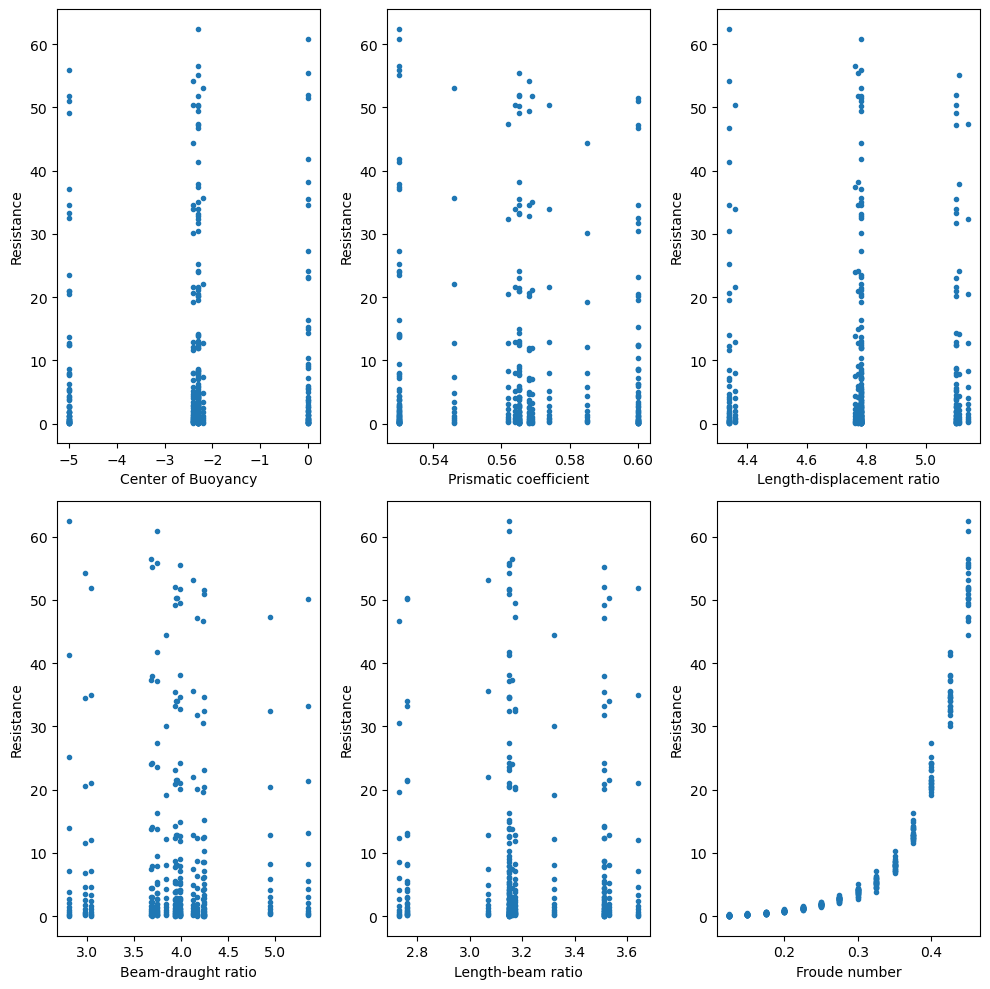

In [182]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(X[:, i] ,T, '.')
    plt.ylabel(Tname)
    plt.xlabel(Xnames[i])
plt.tight_layout()

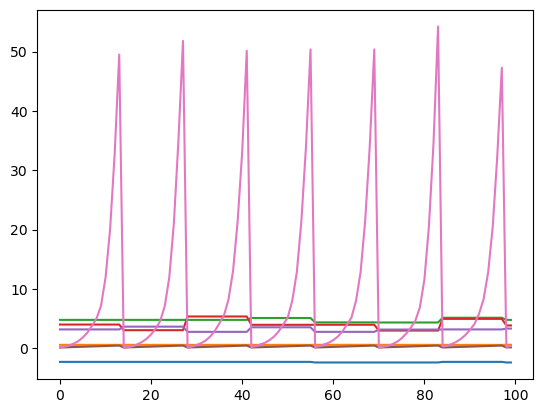

In [184]:
plt.plot(X[:100, :])
plt.plot(T[:100, :])

In [186]:
model_parms = train(X, T, n_epochs=1000, learning_rate=0.01)
predict = use(model, model_parms, X)
print(rmse(predict, T))

8.858204459870853


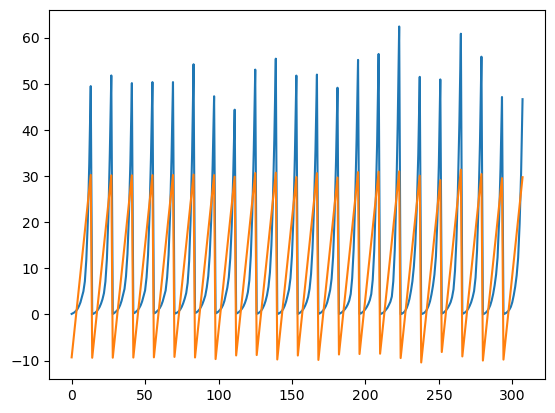

In [188]:
plt.plot(T)
plt.plot(predict);

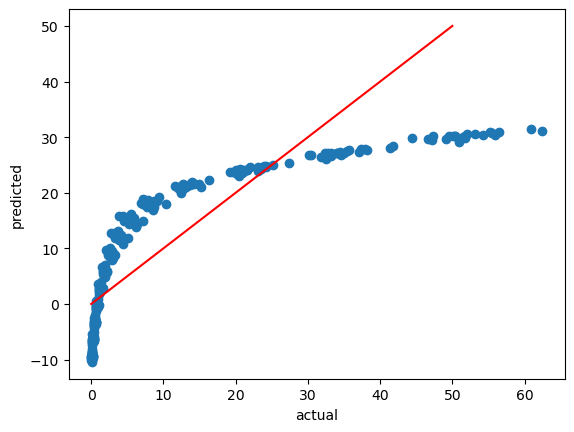

In [190]:
plt.plot(T, predict, 'o')
plt.plot([0, 50], [0, 50],  'r-')
plt.xlabel('actual')
plt.ylabel('predicted');

Humm...that last variable, the Froude number, looks like its square root might be more linearly related to resistance.

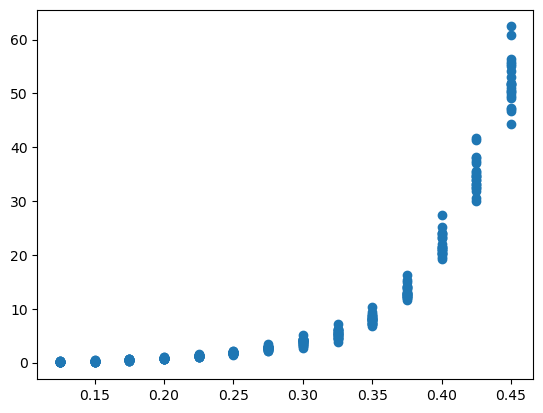

In [192]:
plt.plot(X[:, -1], T, 'o');

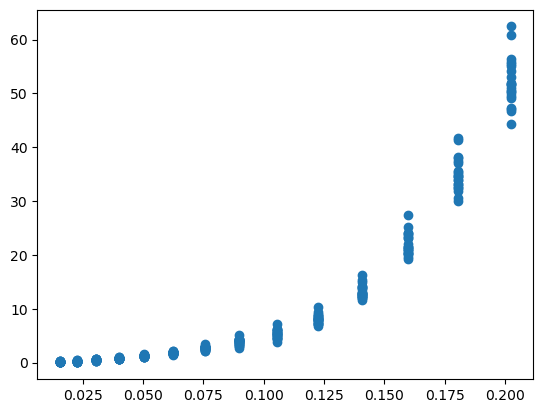

In [194]:
plt.plot(X[:,-1]**2, T, 'o');

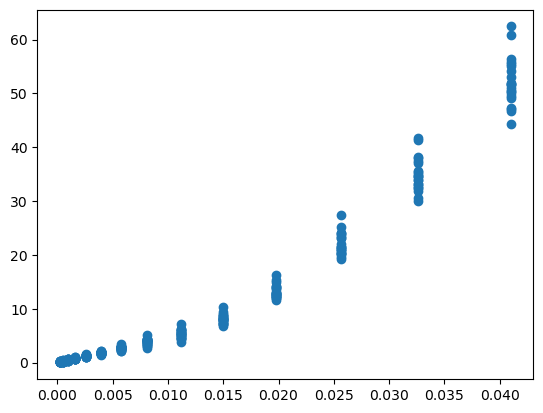

In [196]:
plt.plot(X[:,-1]**4, T, 'o');

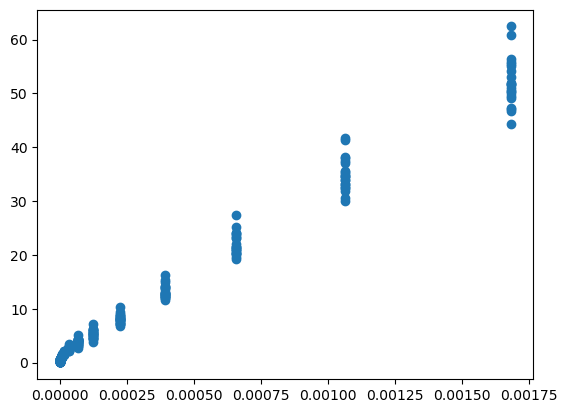

In [198]:
plt.plot(X[:,-1]**8, T, 'o');

In [200]:
Xp = make_powers(X, 5)
model_parms = train(Xp, T,  n_epochs=1000, learning_rate=0.01)
predict = use(model, model_parms, Xp)
print(rmse(predict, T))

2.451727347497778


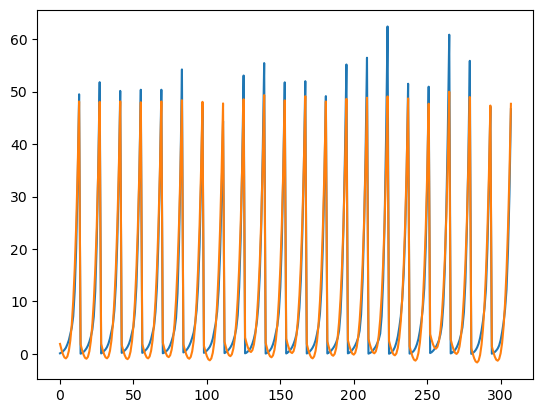

In [202]:
plt.plot(T)
plt.plot(predict);

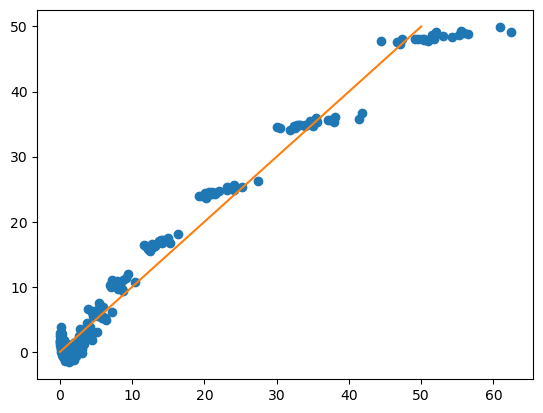

In [204]:
plt.plot(T, predict, 'o')
plt.plot([0, 50], [0, 50]);

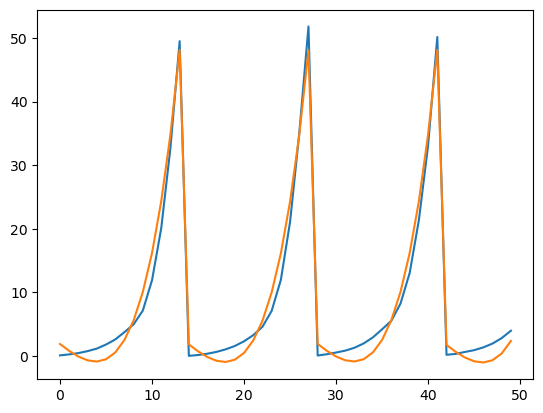

In [206]:
n = 50
plt.plot(T[:n])
plt.plot(predict[:n]);

Maybe higher powers would work better.

In [208]:
result = []
for max_power in range(1, 20):
    Xp = make_powers(X, max_power)
    model_parms = train(Xp, T, n_epochs=1000, learning_rate=0.001)
    error = rmse(use(model, model_parms, Xp), T)
    print(f'{max_power=} {error=}')
    result.append([max_power, error])
result = np.array(result)
result

max_power=1 error=9.123079991789568
max_power=2 error=8.004389830446703
max_power=3 error=6.923049120508793
max_power=4 error=5.833119407483092
max_power=5 error=4.826767433360301
max_power=6 error=3.9683871515606643
max_power=7 error=3.288688888720464
max_power=8 error=2.791605389876085
max_power=9 error=2.460871997975203
max_power=10 error=2.265678904989461
max_power=11 error=2.1684728324879847
max_power=12 error=2.1340190289507093
max_power=13 error=2.135224187325779
max_power=14 error=2.154072620493184
max_power=15 error=2.1797414817646774
max_power=16 error=2.2062084073904997
max_power=17 error=2.2303711266009554
max_power=18 error=2.250813574401558
max_power=19 error=2.2670611966544434


array([[ 1.        ,  9.12307999],
       [ 2.        ,  8.00438983],
       [ 3.        ,  6.92304912],
       [ 4.        ,  5.83311941],
       [ 5.        ,  4.82676743],
       [ 6.        ,  3.96838715],
       [ 7.        ,  3.28868889],
       [ 8.        ,  2.79160539],
       [ 9.        ,  2.460872  ],
       [10.        ,  2.2656789 ],
       [11.        ,  2.16847283],
       [12.        ,  2.13401903],
       [13.        ,  2.13522419],
       [14.        ,  2.15407262],
       [15.        ,  2.17974148],
       [16.        ,  2.20620841],
       [17.        ,  2.23037113],
       [18.        ,  2.25081357],
       [19.        ,  2.2670612 ]])

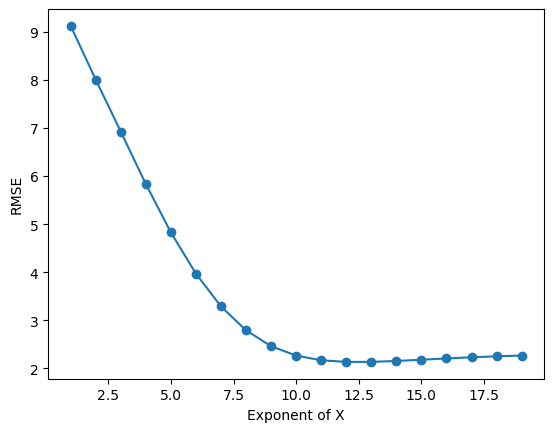

In [210]:
plt.plot(result[:,0],result[:,1],'o-')
plt.xlabel('Exponent of X')
plt.ylabel('RMSE');

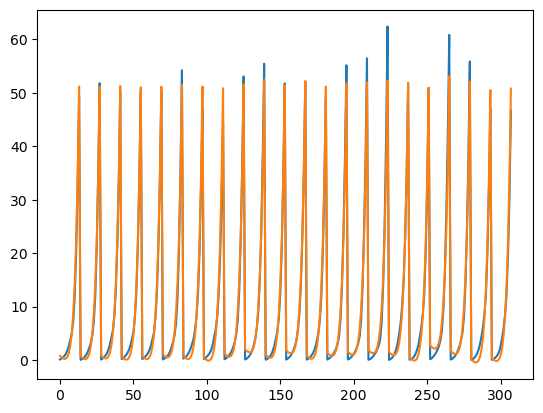

In [212]:
Xp = make_powers(X, 8)
predict = use(model, train(Xp, T, n_epochs=1000, learning_rate=0.01), Xp)
plt.figure()
plt.plot(T)
plt.plot(predict);

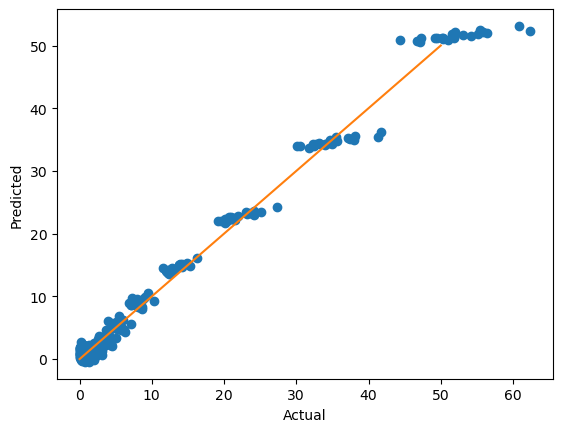

In [214]:
plt.plot(T, predict, 'o')
plt.plot([0, 50], [0, 50])
plt.xlabel('Actual')
plt.ylabel('Predicted');